In [1]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import json
import csv
import logging
from tqdm import tqdm
import torch
import datasets
from datasets.combine import *
import PIL
from collections import OrderedDict
import time
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from timm import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
from torchvision.transforms.v2 import functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kornia import filters
import kornia.augmentation as K


# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually


_URLS = {'root': os.curdir,'cache_dir':"raw"}
_BATCH_SIZE = 16
_NUM_WORKERS = 8
_TRAIN_SPLIT = {'d1':1,'d2':2,'d3':3, 'd4':4}
_VALID_SPLIT = '0'
_TEST_SPLIT = "chabud"


/home/w1nlin4n/miniconda3/envs/pytorch-learning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Тут можна задати спліти 0-4, що дає вчитися і перевіряти метрики на незалежних вибірках



In [2]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])
sys.path.append(os.path.abspath('..'))

# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: ./raw


In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device)

In [4]:
# Load the CaBuAr dataset
# Possible splits: 0-4, or chabud
# For docs check out
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar
d1 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d1']}", trust_remote_code=True)
d2 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d2']}", trust_remote_code=True)
d3 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d3']}", trust_remote_code=True)
d4 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d4']}", trust_remote_code=True)
valid_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_VALID_SPLIT}',trust_remote_code=True).with_format("torch")
test_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TEST_SPLIT}',trust_remote_code=True).with_format("torch")

train_data = interleave_datasets([d1, d2, d3, d4], stopping_strategy='all_exhausted').with_format("torch")


### На основі аналізу датасету запроповані рішення для перетворення датасету
 - Create an class ratio graphic in output mask

Бінарність класів спрощує Segmentation loss в просту бінарну кроссентропію з логітами.
 Використаємо взваження класів відносно їх частоти в зображенні всередині  лосс функції за допомогою class_weights.
Додаємо до BCE лосс-функції додатково Dice loss, що є диферренційованим F1 score

 - Mean brightness, distribution per-channel of images

Додамо першим шаром батч нормалізацію,

**Створимо синтез фіч**:
1.  порахувавши індекс щільності рослинності (NDVI): гіперболічну дистанцію між яскравістю пікселів Червоного (B04), Інфрачервоного (B08) каналів першим каналом,
2. А також для Довгих інфрачервоних DWDM каналів B12 і B11.

3. Останнім каналом візьмемо B09, для відокремлення вологого грунту
від спаленої землі і водних об'єктів.

Присутність великого набору семплів з пустими масками (class 0) підвищує захищеність моделі

Для зменшення шуму окремо згладимо вхідне зображення з Гауссовим блюром

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

Так як не присутня залежність між зображеннями в батчі, регуляризація виконується для кожної пари вхідне зображення --- маска:

1. До вхідного зображення додається невелика кількість шуму

2. З RandomJigsaw синхронно розрізаємо зображення та маску на квадрати NxN і перемішуємо їх

3. Під час тренування для одночасно маски і зображення робимо афінне перетворення, відображаємо вертикально та горизонтально

Ціллю є підвищення інваріантності по переміщенню і обертанню, подальше використання dropout для зменшення глобальних глобальних активацій нейронів, і більшого фокусу моделі на локальних фічах, інваріантно від топографії ландшафту і присутніх на ньому географічних ознак.

## Preprocessing functions



- Hyperbolic difference

Відображає нелінійний ріст залежності, накладає вагу для збільшення контрасту між схожими значеннями і аутлаєрами, додає біас.

In [5]:
def hyperbolic_diff(img_x, img_y, scale = 0.5, bias = 0):
    if bias == -1e-6:
        bias = 0
    return scale * (img_x - img_y) / (img_x + img_y + bias + 1e-6)

Перетворення листків датасету в тензори toTensor замінено на torch.tensor()

- Transform виконується одночасно на вхідному зображенні і масці; стосується лише афінних перетворень без зміни кольорів

- Augmentation - лише для вхідного зображення post_fire - згладжує зображення для ідентифікації грубих фіч, видаляє частину інформації для підвищення робастності на реальному тестуванні

- Important to denoise the data,
 using gaussian blur pyramids

In [6]:
mozaic = K.RandomJigsaw((2, 2), keepdim=True, p=0.2)

gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
adjust_contrast = transforms.ColorJitter(contrast=1.5)

def get_transforms(size):
  return transforms.Compose([
    mozaic,
    transforms.RandomAffine(degrees=10., translate=(0.3, 0.3), interpolation=PIL.Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop(size, pad_if_needed=True, padding_mode='reflect')
])

augmentation = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])

def test_transforms(size):
   return transforms.Compose([transforms.RandomCrop(size, pad_if_needed=True)])


- Define scripts to convert image to 3 channel image
- Define clipping of class values
-  Normalization
- Showing before/after
- Resizing of images, important for  (Optional)

## Three channels
- (Natural Density of Vegetation, Water vapor intensity, medium-long infrared ratio)

- Розділяємо батч на окремі зображення (3, 512, 512) і маску (1, 512, 512)

Видалені канали:

- B01 - рівень аерозолю

- B02, 03 - зелений і синій, видима неозброєним оком рослинність і водойми

- B05-07 - Класифікація рослинних культур

- B10 - Тип хмар

- Всі інші канали крім B04, B08, B09, B11, B12 дропаємо для зменшення зайвого об'єму інформації поданого на вхід, і використання претренованих ваг.


In [7]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        pre_nir = pre_fire[7, :, :]
        pre_red = pre_fire[3, :, :]
        post_nir = post_fire[7, :, :]
        post_red = post_fire[3, :, :]
        
        # Compute hyperbolic difference of channels
        ndvi_pre = hyperbolic_diff(pre_nir, pre_red, scale=5.67, bias=0.5)
        ndvi_post = hyperbolic_diff(post_nir, post_red, scale=5.67, bias=0.5)

        # Return a mean square distance between old and new
        return torch.square(ndvi_post - ndvi_pre)
        #return ndvi_post


    def fire_boundary(self, pre_fire, post_fire):
        # Extract low frequency bands:
        pre_band_11 = pre_fire[10, :, :]
        pre_band_12 = pre_fire[11, :, :]
        boundary_pre = hyperbolic_diff(pre_band_11, pre_band_12, 8.5, 0.5)

        post_band_11 = post_fire[10, :, :]
        post_band_12 = post_fire[11, :, :]
        boundary_post = hyperbolic_diff(post_band_11, post_band_12, 8.5, 0.5)  # Shape: [1, H, W]

        return torch.square(boundary_post - boundary_pre)

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']  # Shape: (512, 512, 12)
        mask = sample['mask']            # Shape: (512, 512, 1)
        pre_fire = sample.get('pre_fire', torch.zeros_like(post_fire))

        # Convert list files into tensors
        pre_fire = pre_fire.to(torch.float).permute(2, 0, 1)
        post_fire = post_fire.to(torch.float).permute(2, 0, 1)
        mask = mask.to(torch.float).permute(2, 0, 1)
        
        # Calculate NDVI - natural vegetation index
        ndvi = self.calculate_ndvi(pre_fire, post_fire)
        
        # Compute fire boundary using sentinel script
        fire_boundary = self.fire_boundary(pre_fire, post_fire)
        
        # Extract water vapor band 09
        water_vapor = hyperbolic_diff(post_fire[8,:,:],pre_fire[8, :, :], bias=5.67)

        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi = self.augment(ndvi.unsqueeze(0))
            water_vapor = self.augment(water_vapor.unsqueeze(0))
            fire_boundary = self.augment(fire_boundary.unsqueeze(0))

        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.stack([ndvi.squeeze(), water_vapor.squeeze(), fire_boundary.squeeze(), mask.squeeze()], dim=0)  # 4 channels]

        # Transform all layers uniformly, to maintain ground truth on validation
        if self.transform:
            combined_input = self.transform(combined_input)

        # Prepare the X_input and y
        return combined_input[:-1], torch.round(combined_input[-1].unsqueeze(0))

Обгортка для передачі даних на CUDA

In [8]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

Train, validation і test лоадери

In [9]:
_INPUT_SIZE = 224
# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDataset(
    hf_dataset=train_data,
    transform=get_transforms(_INPUT_SIZE),
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDataset(
    hf_dataset=valid_data,
    transform=test_transforms(_INPUT_SIZE),
)
test_dataset = CaBuArPyTorchDataset(
    hf_dataset=test_data,
    transform=test_transforms(_INPUT_SIZE)
)

tr_loader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
vd_loader = WrappedDataLoader(DataLoader(
    valid_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
test_loader = WrappedDataLoader(DataLoader(
    test_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

In [10]:
print(f"train: {len(train_dataset)}")
print(f"valid: {len(valid_dataset)}")
print(f"test: {len(test_dataset)}")

train: 340
valid: 78
test: 68


Перевірка на доступність до завантаження файлів датасету

In [11]:
%%time
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(tr_loader):
    X, y = batch

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {X.shape}")
    print(f"  mask shape: {y.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

Batch 0:
  post_fire shape: torch.Size([16, 3, 224, 224])
  mask shape: torch.Size([16, 1, 224, 224])
CPU times: user 191 ms, sys: 316 ms, total: 507 ms
Wall time: 8.79 s


### Відображення результатів препроцессингу

- Виділимо 5 випадкових зображень з train і test спліту

- Train додає трансформації до зображення

- Test показує оригінал без перетворень

### Зауваження

- В датасеті присутні як денні зображення, так і нічні. NDVI індекс виділяється добре лише на денних зображеннях.

In [12]:
idx, processed_img = next(enumerate(tr_loader))

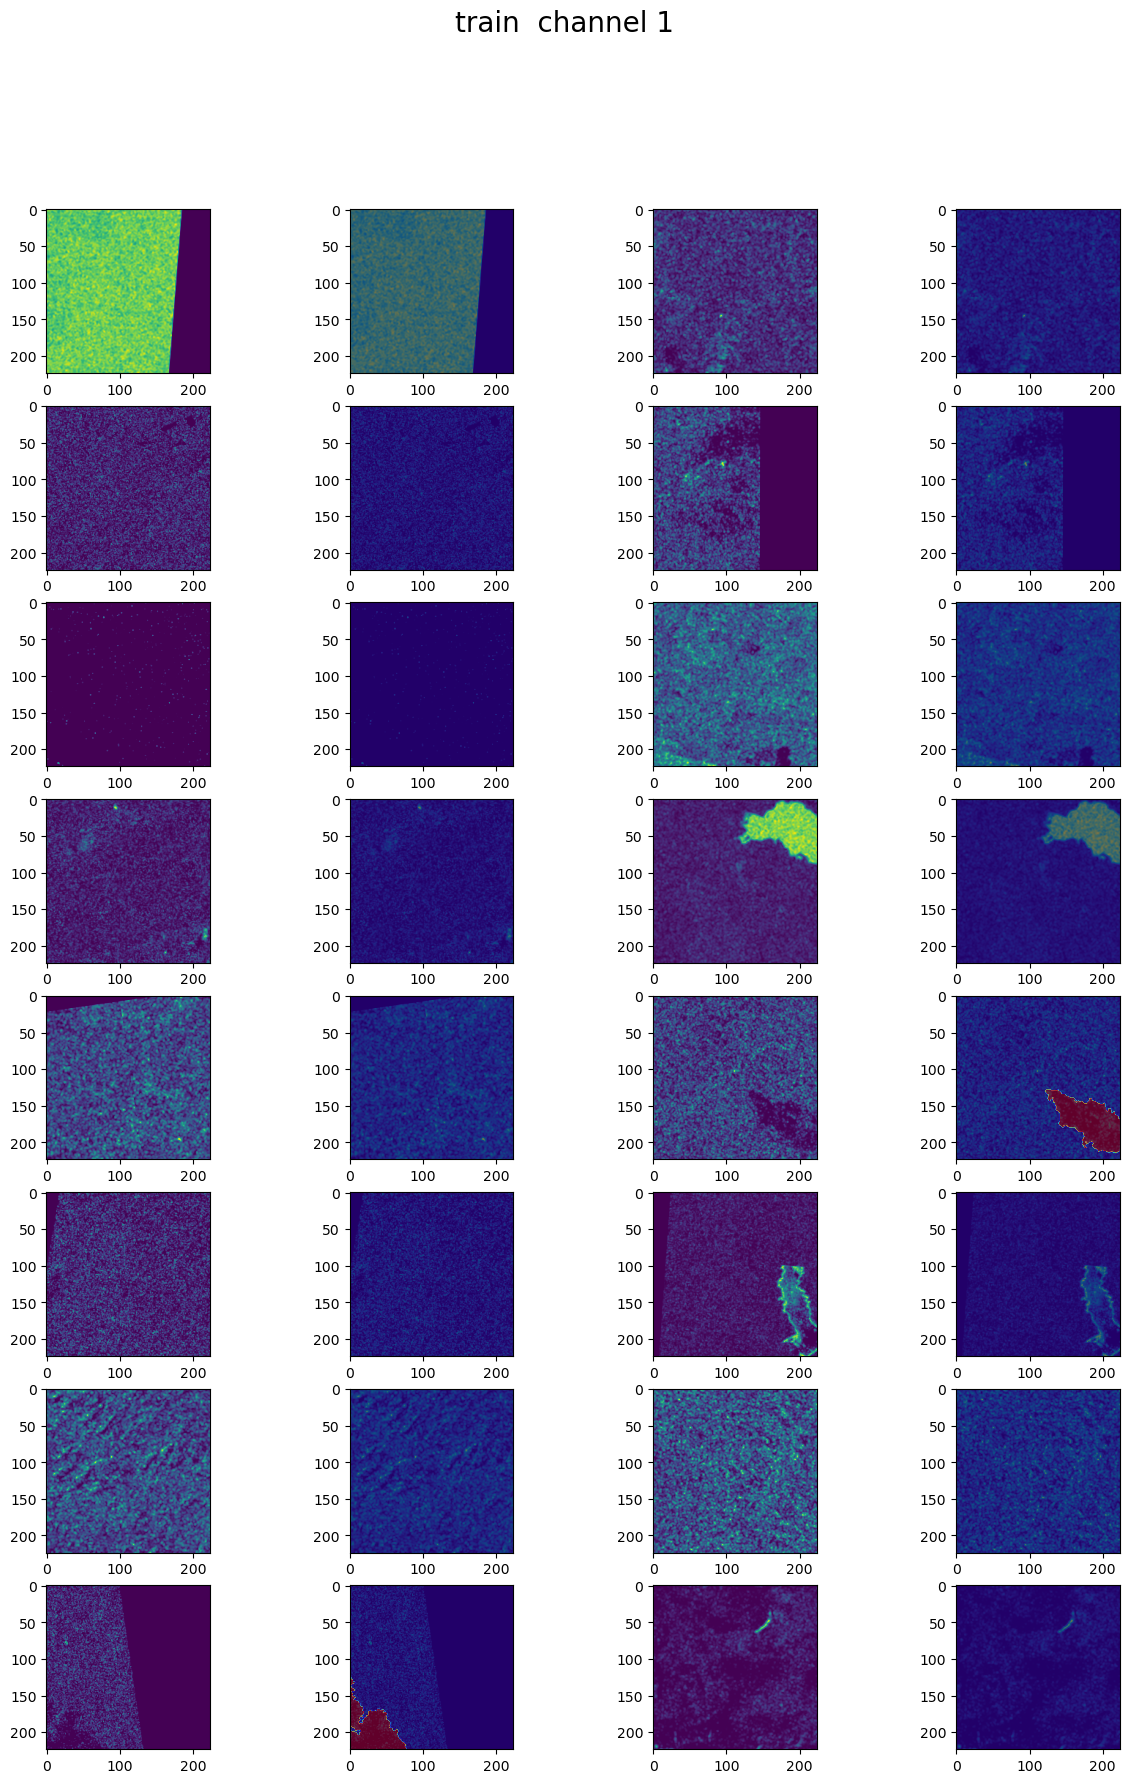

In [13]:

# Let's plot some images
def draw_transforms(batch_img, batch_size, ch, caption:str):
  x, y = batch_img
  fig, axes = plt.subplots(batch_size // 2, 4, figsize=(15,20))
  fig.suptitle(f"{caption}  channel {ch}", fontsize=20)
  im_pos = 0
  for i in range(batch_size):
      axes[im_pos // 4, im_pos % 4].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      im_pos += 1
      axes[im_pos // 4, im_pos % 4].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      axes[im_pos // 4, im_pos % 4].imshow(y[i].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy(), cmap='jet', alpha=0.5)
      im_pos += 1
  plt.show()

draw_transforms(processed_img, _BATCH_SIZE, 1, "train")

In [14]:
idx, test_img = next(enumerate(test_loader))

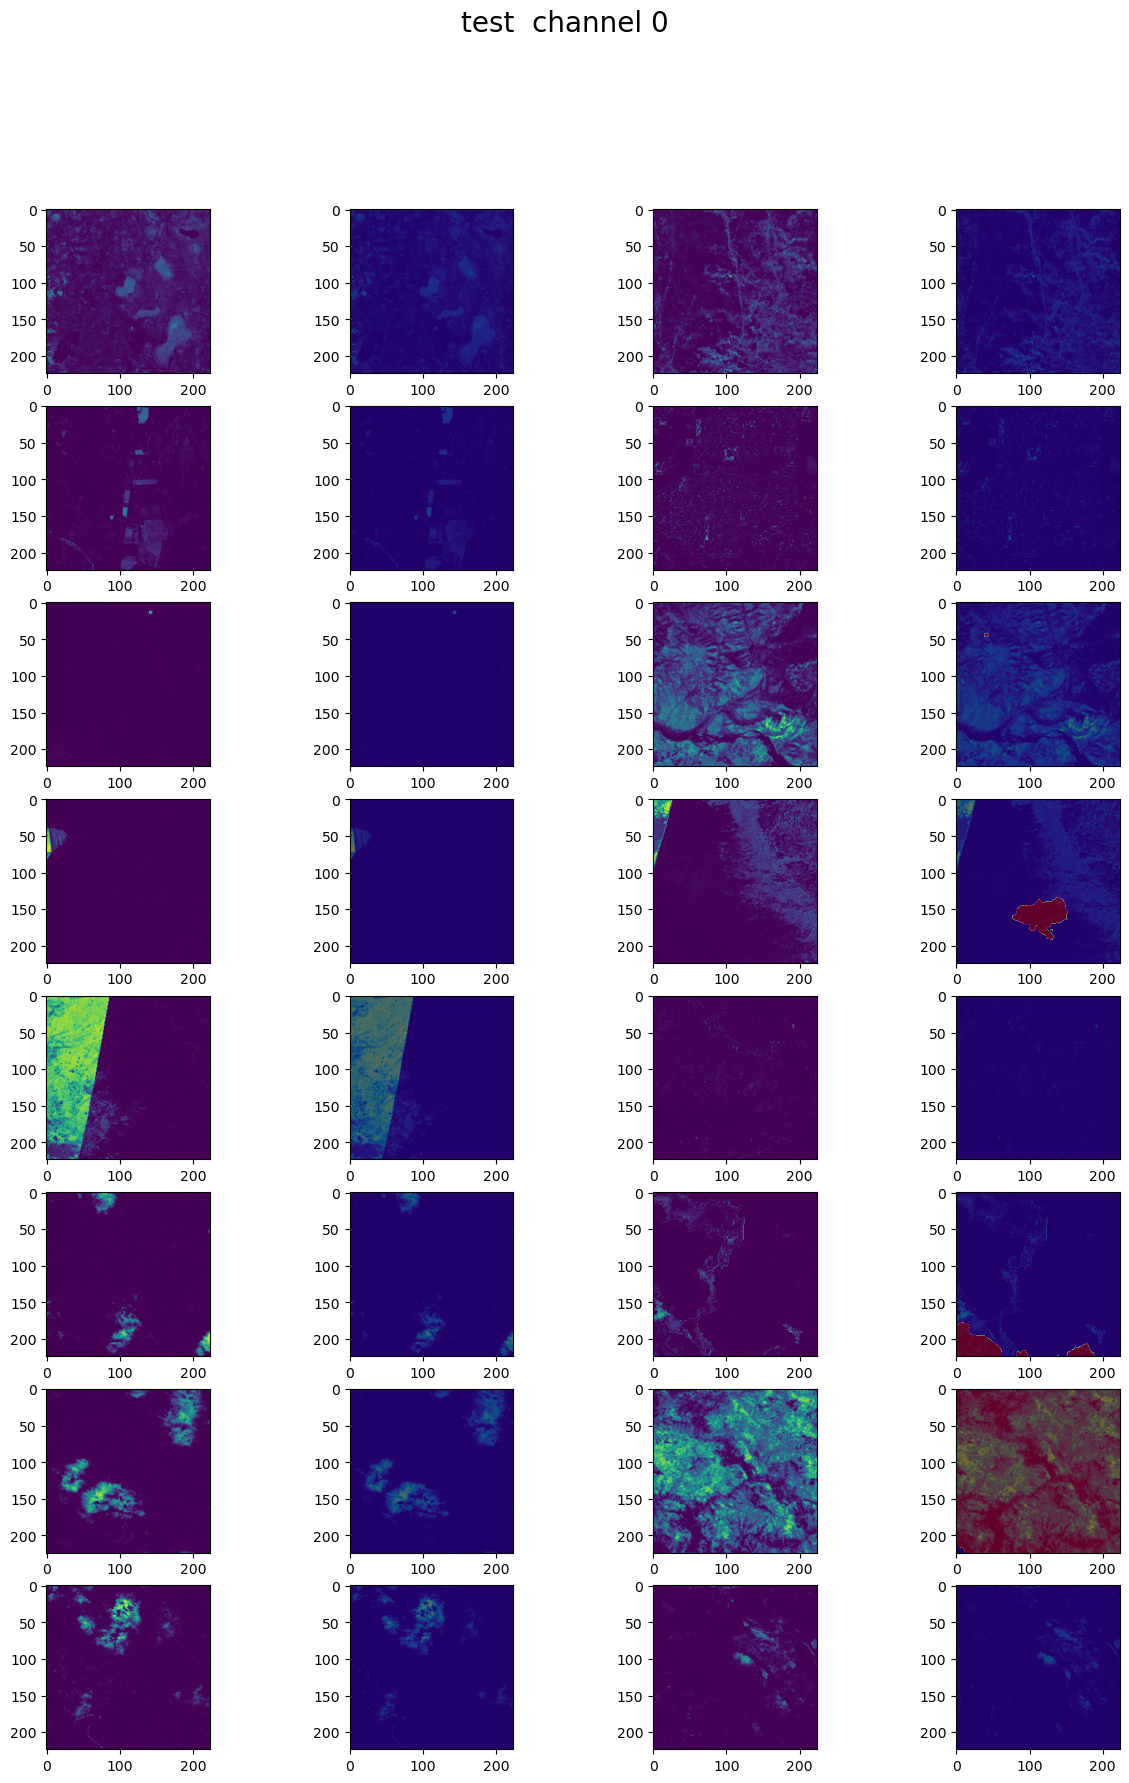

In [15]:
draw_transforms(test_img, _BATCH_SIZE, 0, "test")

## Використовуємо за Loss Combined BCE + F1 (Dice loss)

## Метрики - попіксельно F1/AuC та Extended IoU

Покращений IoU враховує відстань між масками і ground truth навіть за нульового перекриття, уникає плато нульового градієнту.

In [44]:
def write_results(results_file, results, format='csv'):
    with open(results_file, mode='w') as cf:
        if format == 'json':
            json.dump(results, cf, indent=4)
        else:
            if not isinstance(results, (list, tuple)):
                results = [results]
            if not results:
                return
            dw = csv.DictWriter(cf, fieldnames=results[0].keys())
            dw.writeheader()
            for r in results:
                dw.writerow(r)
            cf.flush()

def get_outfile(path, *paths, inc=False):
    outfile = os.path.join(path, *paths)
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    return outfile

def update_summary(epoch, train_metrics, eval_metrics, filename, write_header=False, log_wandb=False):
    rowd = OrderedDict(epoch=epoch)
    rowd.update([('train_' + k, v) for k, v in train_metrics.items()])
    rowd.update([('eval_' + k, v) for k, v in eval_metrics.items()])
    # if log_wandb:
    #     wandb.log(rowd)
    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        if write_header:  # first iteration (epoch == 1 can't be used)
            dw.writeheader()
        dw.writerow(rowd)

In [17]:
class DiceBCELoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.sigmoid(inputs)

        bce = torch.nn.functional.binary_cross_entropy(inputs, targets, weight=weights, reduction='mean')
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        
        return bce + dice_loss

### Не використовується як лосс, а як метрика для порівняння результатів

In [18]:
class Dice(nn.Module):
    def __init__(self, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return dice_score

In [19]:
class IoU(nn.Module):
    def __init__(self, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return IoU

### Додамо ваги класів в лосс для урахування дизбалансу.

In [20]:
total = 512*512*len(train_data)
positive_class = torch.sum(train_data["mask"].to(torch.int))
negative_class = total - positive_class
class_weights = torch.tensor([total / 2 / negative_class, total / 2 / positive_class]).to(device)

In [21]:
### Class imbalance (sometimes a few pixels against a backdrop of a single class)
### Should be solved by applying weight for error on each class by its size

def class_weights_mapping(y):
    return class_weights[y.to(torch.int)]

# Пайплайн тренування і валідації

In [22]:
def loss(model,
         loss_func,
         X, y,
         weights=None,
         optimizer=None
):
    loss_ = loss_func(model(X), y, weights)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), X.size(0)

In [23]:
iou_metric = IoU()
f1_metric = Dice()
def validate(
        model,
        loader,
        loss_fn,
        device=torch.device('cuda'),
        log_suffix='',
        log_frequency=10
):
    batch_time_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()
    top1_m = utils.AverageMeter()
    iou_m = utils.AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = loss_fn.forward(output, target)
            pred = torch.round(output).to(torch.int)
            acc = f1_metric(pred, target)
            iou = iou_metric(pred, target)

            losses_m.update(loss, input.size(0))
            top1_m.update(acc, input.size(0))
            iou_m.update(iou, input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()

    return losses_m.avg, top1_m.avg, iou_m.avg

In [24]:
def fit(epochs,
        batch_size,
        model,
        loss_func,
        optimizer,
        train_loader,
        valid_loader,
        lr_scheduler,
        patience=10,
):
    history = []

    wait = 0
    val_loss_min = torch.inf
    train_loss = utils.AverageMeter()

    for epoch in tqdm(range(epochs)):
        train_loss.reset()
        model.train()
        running_loss = 0.
        losses = []
        for X, y in train_loader:
          weight = class_weights_mapping(y)
          train_loss.update(*loss(model, loss_func, X, y, weight, optimizer))

        if lr_scheduler is not None:
            lr_scheduler.step()

        val_loss, val_f1, val_iou = validate(model, valid_loader, loss_func, device)
        
        print(f"\nepoch: {epoch+1:3}, loss: {train_loss.avg:.5f}, valid loss: {val_loss:.5f}, valid F1 score: {val_f1:.3f}, valid IoU: {val_iou:.3f}")

        history.append((train_loss.avg, val_loss, val_f1, val_iou))


            #TODO
            #update_summary(epoch, )
            # metrics = OrderedDict([('model', type(model)),('loader', type(loader)),('loss', losses_m.avg), ('f1_accuracy', top1_m.avg), ('iou', iou_m.avg)])
            # if results_file is not None:
            #   write_results(results_file, metrics)
            # Save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(f"Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(model.state_dict(), "model.pt")
            val_loss_min = val_loss
            wait = 0
        # Early stopping
        else:
            wait += 1
            if wait >= patience:
                print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                return history

    return history

In [47]:
def train(model, criterion, metric, optimizer, n_epochs, transforms, input_size=512,
          batch=64, saving_model_path=None, lr_scheduler=None):

    train_dataset = CaBuArPyTorchDataset(
        hf_dataset=train_data,
        transform=get_transforms(input_size),
        augment=augmentation
    )
    valid_dataset = CaBuArPyTorchDataset(
        hf_dataset=valid_data,
        transform=test_transforms(input_size)
    )
    test_dataset = CaBuArPyTorchDataset(
        hf_dataset=test_data,
        transform=test_transforms(input_size)
    )

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=batch, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=batch, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=batch, shuffle=False), to_device)

    print("\nFitting nn model")
    start_time = time.time()

    history = fit(n_epochs, batch, model.to(device), criterion, optimizer, train_loader, valid_loader, lr_scheduler)
    t = time.time() - start_time
    print(f'Fit time: {t} s')

    check_point = torch.load("model.pt", map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_f1, test_iou = validate(model, test_loader, criterion, device=device)

    if saving_model_path is not None:
        print("Saving model")
        torch.save(model.state_dict(), get_outfile(saving_model_path))

    print(f"Test loss: {test_loss:.5f}, test F1 score: {test_f1:.3f}, test IoU: {test_iou:.3f}")
    return history

In [26]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# Old weights with accuracy 76.130%
weight = FCN_ResNet50_Weights.DEFAULT
fcn_base_model = fcn_resnet50(weights=weight).to(device)

In [27]:
list(fcn_base_model.children())

[IntermediateLayerGetter(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256

In [28]:
idx, (X_test, y) = next(enumerate(vd_loader))

In [29]:
X_test = X_test.to(device)
for param in fcn_base_model.parameters():
    param.requires_grad = False
output = fcn_base_model.backbone(X_test)

In [30]:
print([(k, v.shape) for k, v in output.items()])

[('aux', torch.Size([16, 1024, 28, 28])), ('out', torch.Size([16, 2048, 28, 28]))]


In [31]:
class FCN_Model(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.backbone = feature_extractor
        self.head_out = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )
        self.head_aux = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = features["out"]
        aux = features["aux"]
        res = self.head_out(out) + self.head_aux(aux)
        return res

In [32]:
fcn_model = FCN_Model(fcn_base_model.backbone, num_classes=1).to(device)

In [33]:
xxx = fcn_model(X_test)

In [34]:
print(xxx.shape)

torch.Size([16, 1, 224, 224])


### Test output

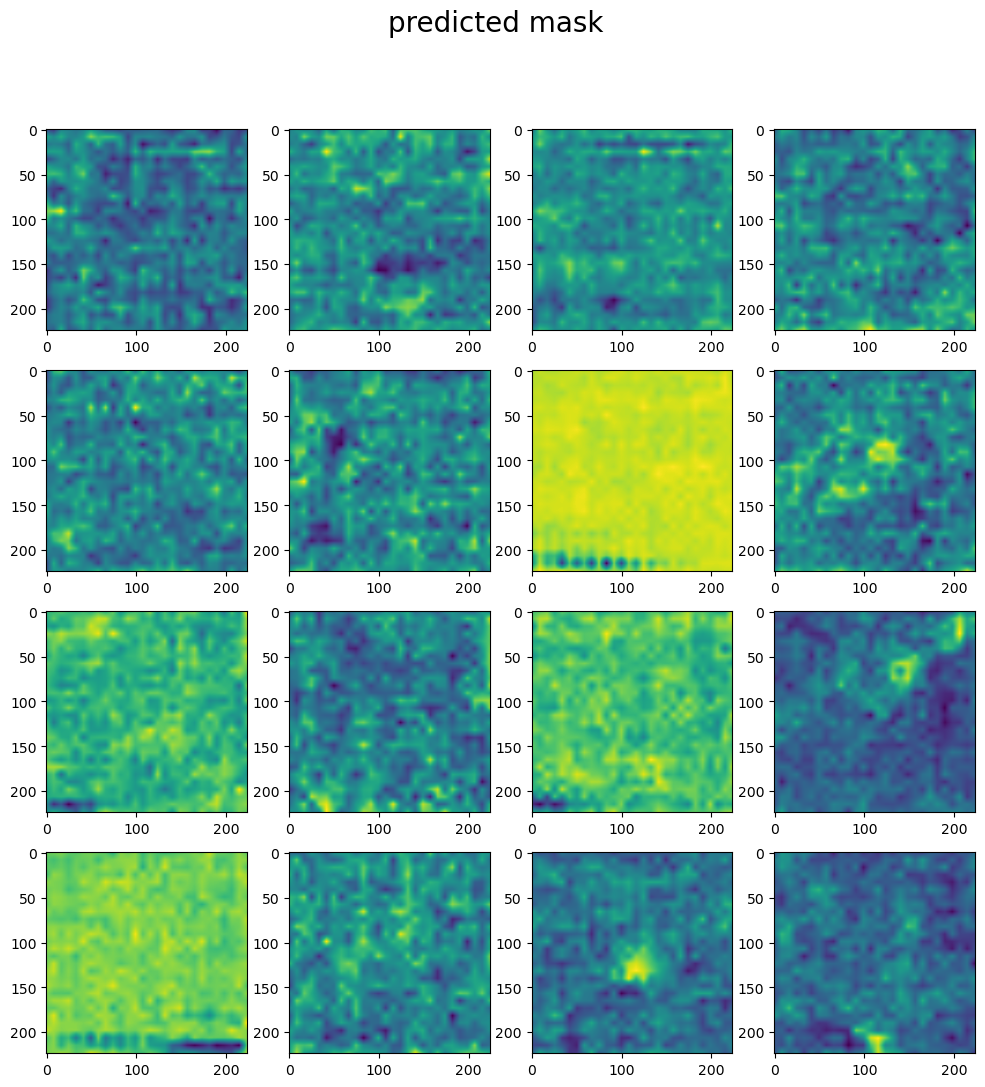

In [35]:
fig, axes = plt.subplots(_BATCH_SIZE // 4, 4, figsize=(12,12))
fig.suptitle(f"predicted mask", fontsize=20)
for i in range(_BATCH_SIZE):
    axes[i // 4, i % 4].imshow(xxx[i].view(_INPUT_SIZE,_INPUT_SIZE,1).detach().cpu().numpy())
plt.show()

### Test pipeline

In [36]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=0.003, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.3)

In [37]:
res = validate(fcn_model, vd_loader, criterion, device=device)

In [38]:
res

(tensor(1.5013, device='cuda:0'),
 tensor(2.8628e-05, device='cuda:0'),
 tensor(2.8628e-05, device='cuda:0'))

In [39]:
fit(1, _BATCH_SIZE,
        fcn_model,
        criterion,
        optimizer,
        tr_loader,
        vd_loader,
        lr_scheduler,
        patience=10
)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]


epoch:   1, loss: 1.36180, valid loss: 3.06109, valid F1 score: 0.219, valid IoU: 0.125
Validation loss decreased (inf --> 3.061090). Saving model...


 20%|████████████████▊                                                                   | 2/10 [00:29<01:57, 14.70s/it]


epoch:   2, loss: 0.87385, valid loss: 6.00964, valid F1 score: 0.133, valid IoU: 0.073


 30%|█████████████████████████▏                                                          | 3/10 [00:49<01:59, 17.02s/it]


epoch:   3, loss: 0.91727, valid loss: 3.78962, valid F1 score: 0.094, valid IoU: 0.050


 40%|█████████████████████████████████▌                                                  | 4/10 [01:17<02:07, 21.32s/it]


epoch:   4, loss: 0.80882, valid loss: 4.74903, valid F1 score: 0.175, valid IoU: 0.097


 50%|██████████████████████████████████████████                                          | 5/10 [01:32<01:36, 19.32s/it]


epoch:   5, loss: 0.93719, valid loss: 10.37823, valid F1 score: 0.046, valid IoU: 0.024


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [01:47<01:10, 17.72s/it]


epoch:   6, loss: 0.87352, valid loss: 6.17329, valid F1 score: 0.359, valid IoU: 0.226


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [02:00<00:48, 16.03s/it]


epoch:   7, loss: 0.88518, valid loss: 9.52211, valid F1 score: 0.072, valid IoU: 0.037


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [02:13<00:30, 15.28s/it]


epoch:   8, loss: 0.96082, valid loss: 3.63411, valid F1 score: 0.044, valid IoU: 0.023


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [02:27<00:14, 14.65s/it]


epoch:   9, loss: 0.80222, valid loss: 5.57478, valid F1 score: 0.035, valid IoU: 0.018


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.93s/it]


epoch:  10, loss: 0.84548, valid loss: 7.14447, valid F1 score: 0.044, valid IoU: 0.024


[(1.3617985080270205,
  tensor(3.0611, device='cuda:0'),
  tensor(0.2189, device='cuda:0'),
  tensor(0.1252, device='cuda:0')),
 (0.8738509136087754,
  tensor(6.0096, device='cuda:0'),
  tensor(0.1335, device='cuda:0'),
  tensor(0.0729, device='cuda:0')),
 (0.9172657097087187,
  tensor(3.7896, device='cuda:0'),
  tensor(0.0937, device='cuda:0'),
  tensor(0.0501, device='cuda:0')),
 (0.8088244606466855,
  tensor(4.7490, device='cuda:0'),
  tensor(0.1746, device='cuda:0'),
  tensor(0.0970, device='cuda:0')),
 (0.9371933516334084,
  tensor(10.3782, device='cuda:0'),
  tensor(0.0459, device='cuda:0'),
  tensor(0.0243, device='cuda:0')),
 (0.8735225130529964,
  tensor(6.1733, device='cuda:0'),
  tensor(0.3586, device='cuda:0'),
  tensor(0.2261, device='cuda:0')),
 (0.8851776978548835,
  tensor(9.5221, device='cuda:0'),
  tensor(0.0715, device='cuda:0'),
  tensor(0.0372, device='cuda:0')),
 (0.9608202864142025,
  tensor(3.6341, device='cuda:0'),
  tensor(0.0441, device='cuda:0'),
  tensor(0.

In [48]:
train(fcn_model, criterion, metric, optimizer, 1, get_transforms(_INPUT_SIZE), input_size=_INPUT_SIZE,
          batch=16, saving_model_path="raw/fcn_model.pt", lr_scheduler=lr_scheduler)


Fitting nn model


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]


epoch:   1, loss: 1.00863, valid loss: 6.50741, valid F1 score: 0.024, valid IoU: 0.012
Validation loss decreased (inf --> 6.507406). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.62s/it]
/tmp/ipykernel_23400/1912601684.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Fit time: 21.62554669380188 s
Saving model
Test loss: 12.29500, test F1 score: 0.014, test IoU: 0.007


[(1.0086273137260886,
  tensor(6.5074, device='cuda:0'),
  tensor(0.0243, device='cuda:0'),
  tensor(0.0124, device='cuda:0'))]